# **Time Series decomposition techniques**
### This notebook is deeply based on the book "Makridakis, Wheelwright & Hyndman - Forecasting, Methods and Applications." on chapter 3, (Times Series Decomposition). The objective is apply the described techniques of classical decomposition to anyone who wants a on-hands learning, since this classic techniques, are still important to understand the fundamental aproacch.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
bikes_data = pd.read_csv("/kaggle/input/bike-sales-in-europe/Sales.csv",parse_dates = ["Date"])
bikes_data = bikes_data.set_index("Date").to_period('D').sort_index()

## **What is?**
### The decomposition principle is based in separate the basicly 3 fundamentals parts of a some kinds of time series data: Trend-cicle, Seasonality and random error, for this definition, random is part of the series, but some defitions can say that the series is formed just by Trend-cicle and Seasonality, the error component is more something aside from the data.

## **Trend-cicle**
### Trend-cylce - It is the combination of two components.Trend is a long term movement of the series, defining the direction where the series go; and the cycle, is the smooth pattern that follows the trend and it represents a pattern of variation, ups and downs that dont follow a strict date pattern, meaning that they are time independitly.
## **Seasonaliy**
### Seasonaliy - time dependent variation that goes with trend-cycle, his occurrence tends to repeat itself in a defined date stamp, it can show some variation in his behaviour caused by the variation.In bussiness and sales analytics it can represent holidays,the production of a product falling caused by the winter or even the Christmas and a lot of other things!.
## **Random error**
### Random error - The true definition of random error can be more broadly, it can represent outliers or metrics erros, it can be visualized as a noise in the data, the diference that rests when you take the trend-cycle and the seasonality from the data, it is useful to say that this noise can cause a lot of trouble when working in a forecast model.

## **Why decomposition?**
### In data analysis, more than the build models and adjust parameters, visualize and understand the data well is a crucial part to be able to solve real word problems, in a techinical or fundamental approach, information is a key word to take the righ decision. Decomposition helps to extract information when separating these components; so a basicly principle to understand is that some kind of time series can be described as a function like  this: data = f(Trend-Cycle, Seasonality,error).

# **Visualizing the data**

### **Working with a bike sales date, focusing in the sales quantity, the US is choosed as the country to work with**

In [3]:
bikes_data.head()

,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
Date,,,,,,,,,,,,,,,,,
2011-01-01,1,January,2011,42,Adults (35-64),M,United States,California,Bikes,Road Bikes,"Road-750 Black, 44",1,344,540,185,344,529
2011-01-01,1,January,2011,33,Young Adults (25-34),F,France,Yveline,Bikes,Road Bikes,"Road-150 Red, 48",2,2171,3578,1097,4342,5439
2011-01-01,1,January,2011,17,Youth (<25),M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44",1,1519,2443,900,1519,2419
2011-01-01,1,January,2011,39,Adults (35-64),M,United States,Washington,Bikes,Road Bikes,"Road-550-W Yellow, 38",3,713,1120,482,2139,2621
2011-01-01,1,January,2011,23,Youth (<25),M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46",1,1252,2295,561,1252,1813


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


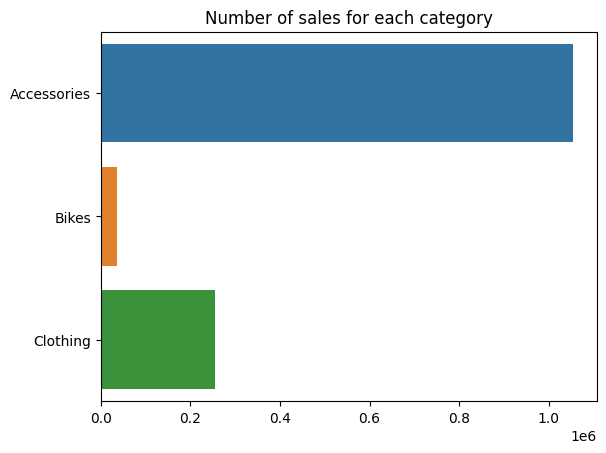

In [4]:
sum_per_category = bikes_data.groupby("Product_Category")["Order_Quantity"].sum()
sum_per_category
categories, values = list(zip(*(sum_per_category.items())))
ax = sns.barplot(y = list(categories) , x = list(values))
ax.set_title('Number of sales for each category')
plt.show()

## Grouping the data of bikes sales for each state, and than, choosing the Bikes sales as target

In [5]:
sum_bike_per_US_state = bikes_data.loc[(bikes_data["Product_Category"] == "Bikes") & (bikes_data["Country"] == "United States")].groupby(["Date" , "State"])["Order_Quantity"].sum().to_frame()
sum_bike_per_US_state

Order_Quantity
Date       State                     
2011-01-01 California               1
           Washington               3
2011-01-02 California               1
2011-01-03 California               5
2011-01-04 California               2
...                               ...
2016-06-28 Washington              12
2016-06-29 California               8
           Oregon                   3
2016-06-30 California               6
           Washington               1

[3370 rows x 1 columns]

<Axes: >

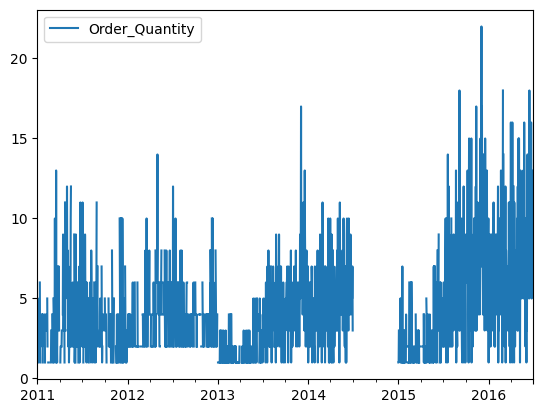

In [6]:
### WITH THE SELECTED STATE, NOW WE HAVE THE ALMOST FINAL FORM OF THE DATA THE WE WILL WORK WITH

choosed_state = "California"
bike_sales = sum_bike_per_US_state.reset_index()
bike_sales = bike_sales.loc[bike_sales["State"] == choosed_state].set_index("Date")

### In this step we try to make sure that all the valid days are available in the data to keep time consistency

complet_index_df = pd.DataFrame(index=pd.period_range(start='2011-01-01', end='2016-06-30', freq='D'))
bike_sales = complet_index_df.join(bike_sales,how = "left")
bike_sales.plot()

## In the previous step, with the completude of the days garanteed, its possible to see that the series has a lot of missing points, so a basicly aproach is combine the interpolation with a moving average to smoothing .

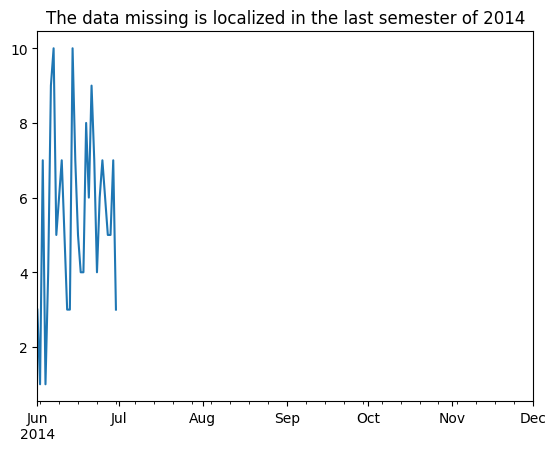

In [7]:
bike_sales.loc["2014-06-01":"2014-12-01","Order_Quantity"].plot()
plt.title("The data missing is localized in the last semester of 2014")
plt.show()

### *For smoothing now the moving average will be used, it transforms the data reducing the high variance in the values that are closer to each other; how much close? Well, it depends on the choosed window size, there is a trade off between losing information and highligntning the desired pattern. Actually the smoothing process is crucial part on the theme of this notebook, where its him the one thas play the role to highlight the trend-cycle to work in the decomposition.*

<Axes: >

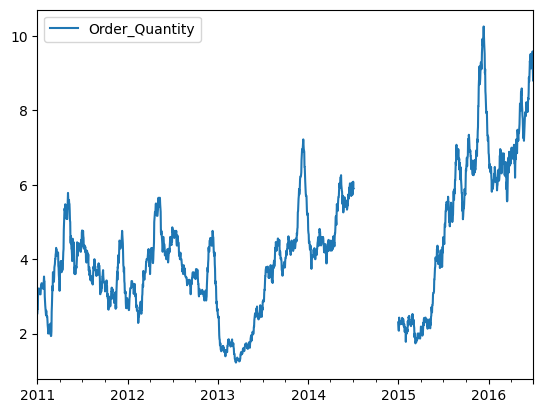

In [8]:
bike_sales["Order_Quantity"].rolling(window = 27,center = True,min_periods = 10).mean().to_frame().plot()

## In the first moment, looks that the data follows a up and down cycle that will match with the interpolation in a satisfactory way, its never sure, of course, that this gap is a down movement, but in the decompositions steps, it will be possible to visualize more clear

<Axes: >

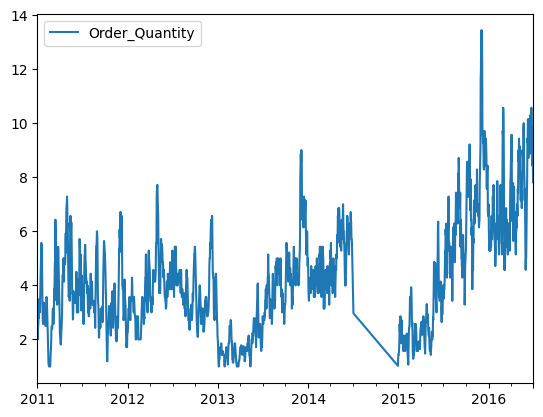

In [9]:
## Filling

index = bike_sales.index
bike_sales["Order_Quantity"] = bike_sales.reset_index()["Order_Quantity"].interpolate(method='polynomial', order=1).rolling(window = 7,center = True,min_periods = 3).mean().values
bike_sales.index = index
bike_sales.plot()

In [10]:
bike_sales_state = bike_sales

## Moving average as a smoothing process, is a fast and simple solution, it reduce the noise and it will be used here in the decompositon process.Bellow are different moving average sizes and its effects in the data. As the window size of the moving average grows the values in the small region desapear and what its captured is the more global behaviour of the serie

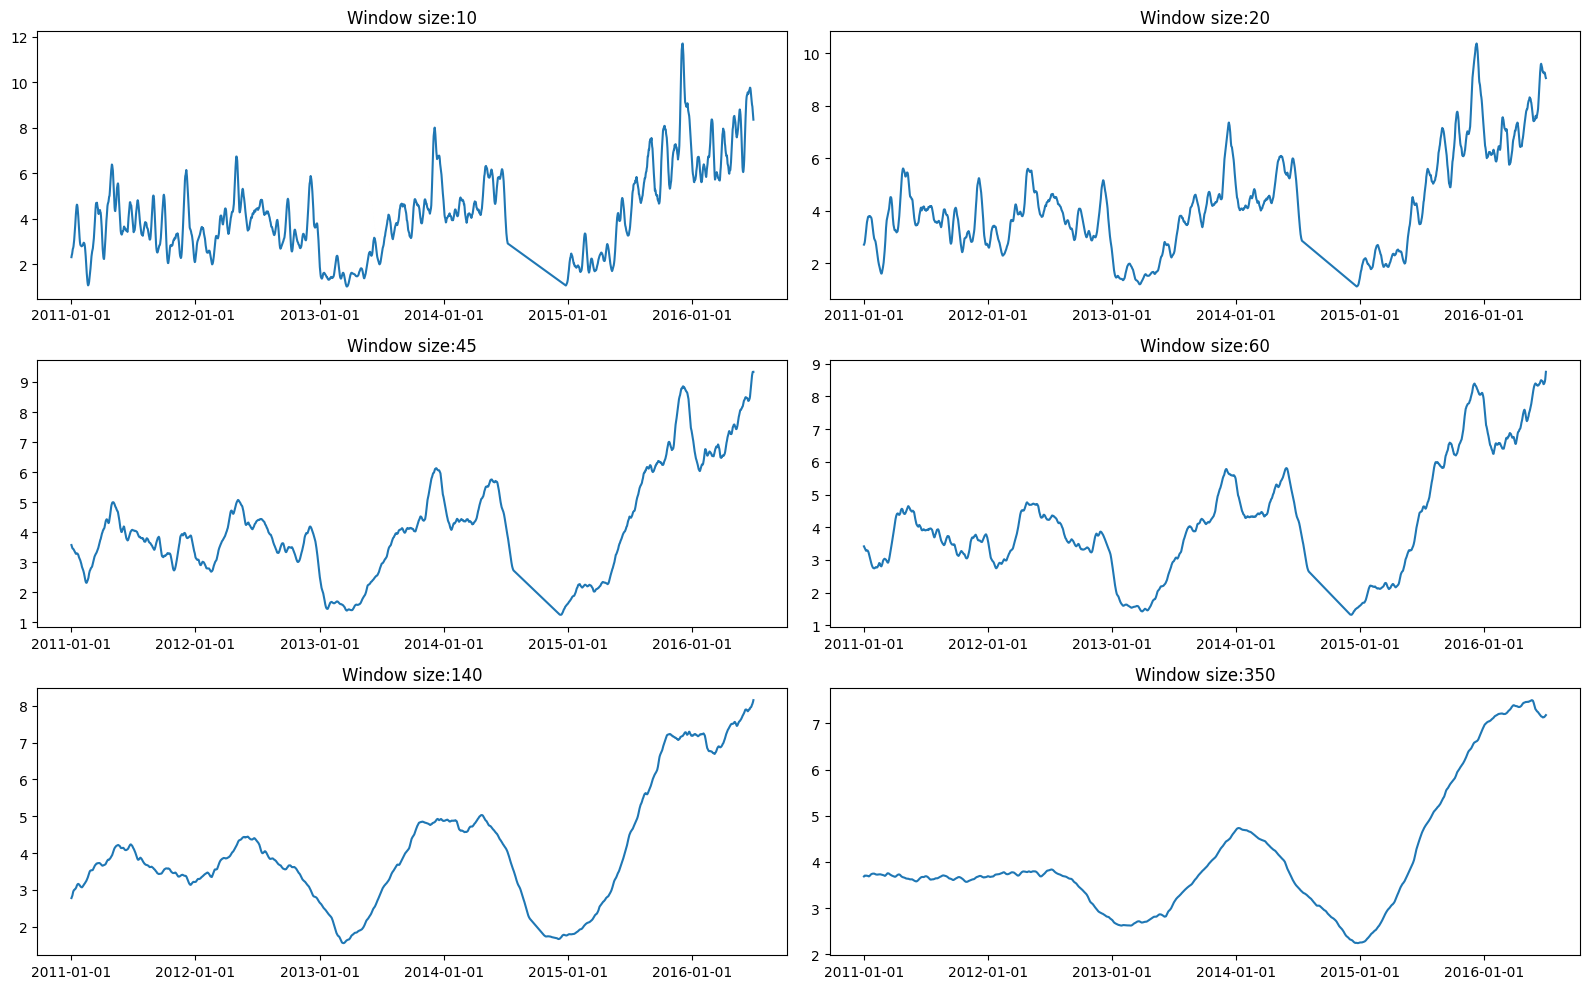

In [11]:
windows_size = [10,20,45,60,140 ,350]

fig, axs = plt.subplots(-(-len(windows_size)//2),2,figsize=(16,10))
for index , window in enumerate(windows_size):
    col = index % 2
    row = int(index/ 2)
    data_to_plot = bike_sales_state["Order_Quantity"].rolling(window = window ,center=True,      
    min_periods=int(window/3),
    ).mean()
#     data_to_plot = data_to_plot.rolling(window = int(window/2) ,center=True,      
#     min_periods=int(window/3),
#     ).mean()
    axs[row][col].plot(data_to_plot.index.map(str),data_to_plot )
    axs[row][col].set_title(f"Window size:{window}")
    axs[row][col].set_xticks(["2011-01-01",  "2012-01-01" , "2013-01-01", "2014-01-01","2015-01-01" ,"2016-01-01"])
fig.tight_layout()

## **RESAMPLING** - To work in the data set, a month resampling will be the approach to defintly get overral behaviour of the data but most important, to kepp all the years of thr set with the same patterns,this will be important soon, cause some mothns have more days than others and this would become a much more boring task

/tmp/ipykernel_18/1414327188.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  bike_sales_state = bike_sales_state.resample('M').sum()


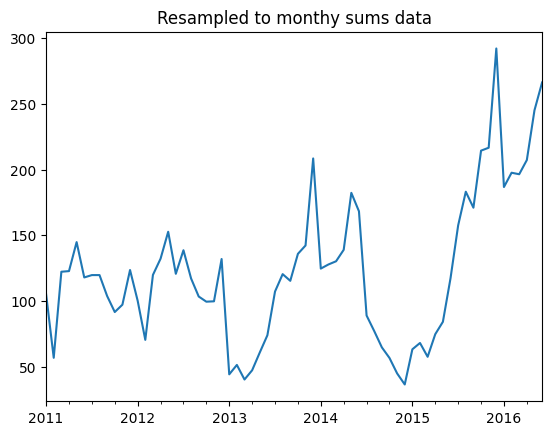

In [12]:
bike_sales_state = bike_sales_state.resample('M').sum()
bike_sales_state["Order_Quantity"].plot()
plt.title("Resampled to monthy sums data")
plt.show()

# **Kinds of decompositions and tranformation**

## Now that it has a better view of the data, it can go back to inital goal: the decomposition.
## The first thing to notice is that the "order quantity" behaviour follows a shape that repeats itself in a one year window, that is the seasonality that we are looking for, the patterns looks like is lacking in the years of 2013 and ends of 2014 to 2015, but the bet here is that what is happening, is the effect of the trend-cycle over the seasonal data, as the trend do his movement, the seasonal data suffer a distortion. To extract her from the data, we will first get the trend-cycle.

In [13]:
def triangular_window(N):
    return 1 - np.abs(np.arange(N) - (N - 1) / 2) / ((N - 1) / 2)

def moving_average_with_window(data,window_size = 5):
    half_window = window_size // 2
    smoothed_data = np.full(data.shape, np.nan)  # Inicializar com NaN
    for i in range(0,data.size):
        lf_index = max(0,i - half_window )
        rg_index = min(data.size - 1, i + half_window)
        w_window = triangular_window(rg_index - lf_index + 1)

        smoothed_data[i] = np.dot(data[lf_index:rg_index + 1], w_window / w_window.sum())

    return smoothed_data


In [14]:
moving_average_with_window(np.array([1,2,3,3,4,3,1,2,4,1,1,2,2,1,2]))

array([2.  , 2.5 , 2.75, 3.25, 3.5 , 2.75, 1.75, 2.25, 2.75, 1.75, 1.25,
       1.75, 1.75, 1.5 , 1.  ])

<Axes: title={'center': 'Trend-Cycle daily data'}>

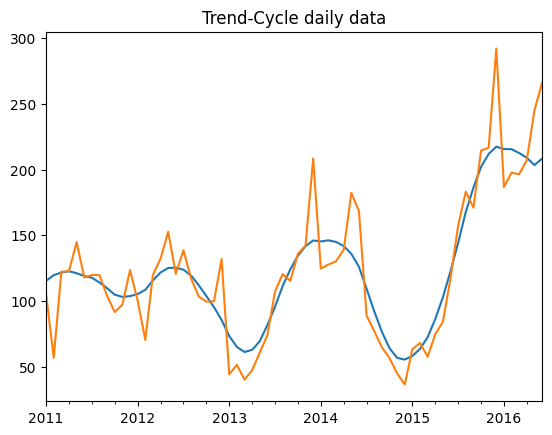

In [15]:

trend_cycle_data = pd.DataFrame()
trend_cycle_data["Order_Quantity"] = moving_average_with_window(bike_sales_state["Order_Quantity"],(10))
trend_cycle_data.index = bike_sales_state.index
plt.title("Trend-Cycle daily data")
trend_cycle_data["Order_Quantity"].plot()
bike_sales_state["Order_Quantity"].plot()

## **Diferents kinds of decomposition**

### **Now that we have the trend_cicle_c in 'trend_cycle_data' we finally will be able to decompose the series; there are some  slighty diferent approaches to deal with**

###  - The additive decompositon consider the data formed by sum of the componentes, this is better suitable when your series is more *static* so the seasonality dont suffer from high distortion
### - The multiplicative decomposition consider a non static data, it infers that the series is composed by the multiplication of the components
### - The log transformation is basicly a math tricky that has the same use as the multiplicative, but it can help to deal with some extra noise due the transformation, the math explanation is: log(Series) = log(Cycle * Seasonality * error) == log(Series) = log(Cycle) + log(Seasonality) + log(error); so when applying a log tranfomation to a series with multiplicative components, the decomposition can be made by an additive process

## It can be observed that the additive and the multiplicative decomposition, results in basicly result, this is caused by the fact the the seasonality dont suffer a high distortion due the trend-cycle, their amplitude and its not so affected by movement of the series.

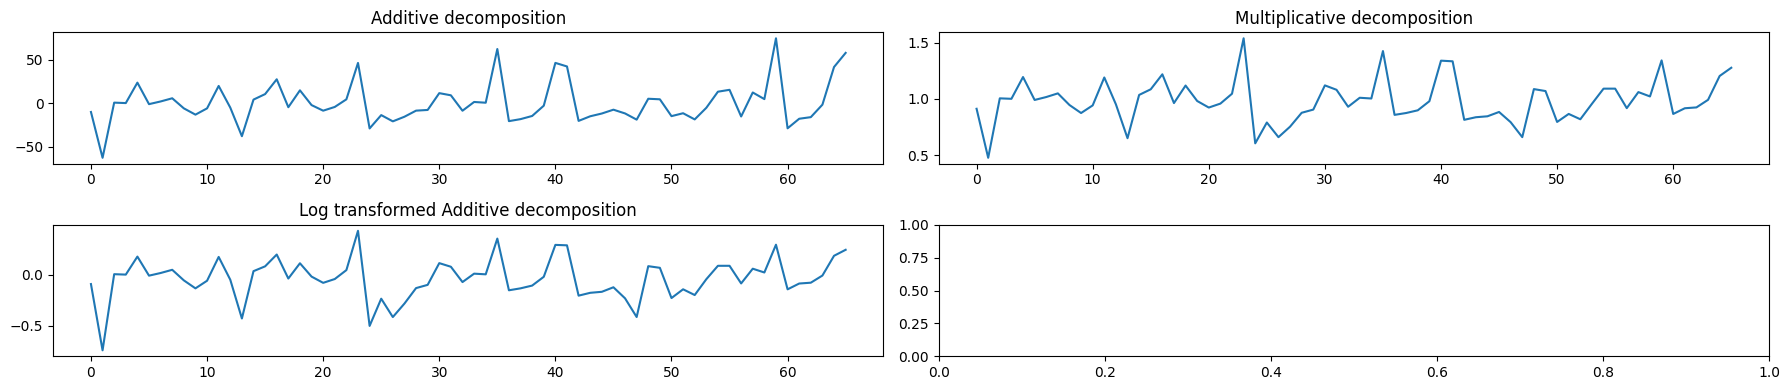

In [16]:
fig , axis = plt.subplots(2,2,figsize = (18,4))

axis[0][0].plot(bike_sales_state["Order_Quantity"].values - trend_cycle_data["Order_Quantity"].values)
axis[0][0].set_title("Additive decomposition")
axis[0][1].plot(bike_sales_state["Order_Quantity"].values / trend_cycle_data["Order_Quantity"].values)
axis[0][1].set_title("Multiplicative decomposition")
axis[1][0].plot(np.log(bike_sales_state["Order_Quantity"].values) - np.log(trend_cycle_data["Order_Quantity"].values))
axis[1][0].set_title("Log transformed Additive decomposition")
# axis[1][1].plot(us_sales_bikes_month["Order_Quantity"].values / trend_cicle_c_month["Order_Quantity"].values) 
plt.tight_layout()

<Axes: >

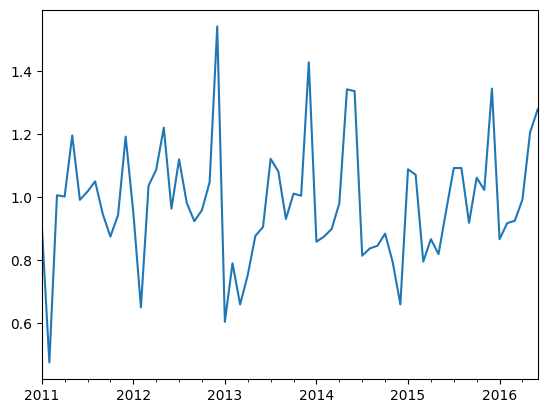

In [17]:
seasonal_error = pd.DataFrame(bike_sales_state["Order_Quantity"].values / trend_cycle_data["Order_Quantity"].values,index=bike_sales_state.index)
month_agregade_seasonal_error = seasonal_error
month_agregade_seasonal_error["year"] = month_agregade_seasonal_error.index.year
# month_agregade_seasonal_error.dropna(inplace = True)
month_agregade_seasonal_error
seasonal_error[0].plot()

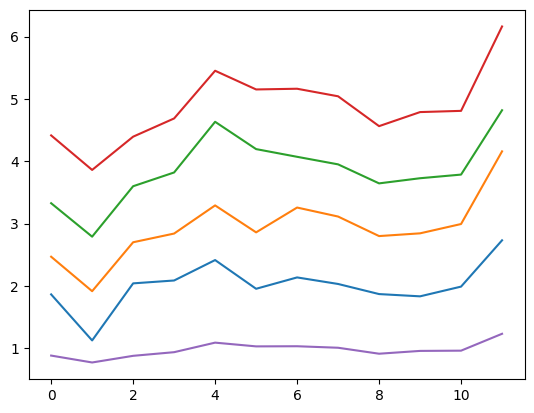

In [18]:
import math
data_calc = month_agregade_seasonal_error.loc[month_agregade_seasonal_error["year"] == 2011][0].values
for year in [2012,2013,2014,2015]:
    
    val = month_agregade_seasonal_error.loc[month_agregade_seasonal_error["year"] == year][0].values
#     if pd.isna(val[0]):
#         print(val)
    data_calc = data_calc + val
    plt.plot(data_calc)
data_calc = data_calc / 5
plt.plot(data_calc)

In [19]:
data_calc

array([0.8827795 , 0.77202803, 0.87871386, 0.93716838, 1.09019826,
       1.03018672, 1.03246593, 1.00824337, 0.91249317, 0.9575979 ,
       0.96152455, 1.23218834])

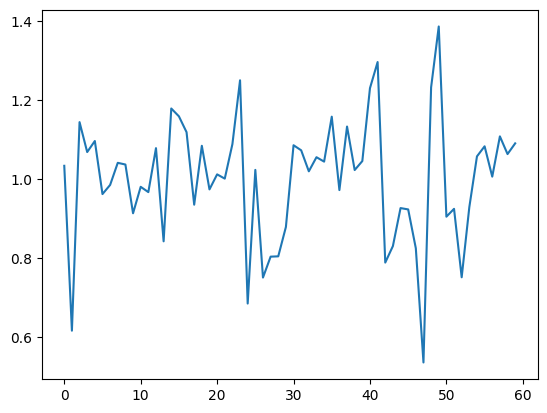

In [20]:
residual = pd.DataFrame(month_agregade_seasonal_error.loc["2011-01":"2015-12",0].values / pd.concat([pd.DataFrame(data_calc)]* 5, ignore_index=True)[0].values)
plt.plot(residual)

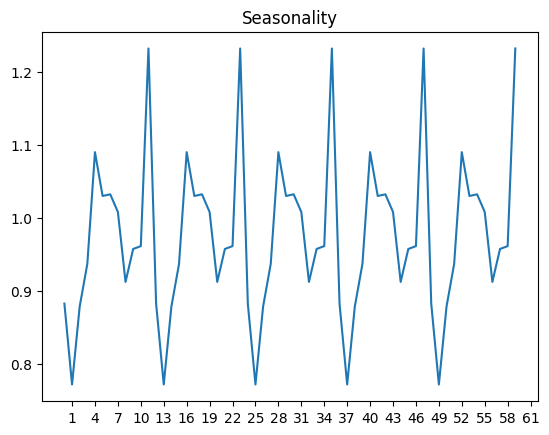

In [21]:
# plt.scatter(list(range(1,61,1)),(month_agregade_seasonal_error.loc["2011-01":"2015-12" ,0].values / residual[0]))
plt.plot((month_agregade_seasonal_error.loc["2011-01":"2015-12" ,0].values / residual[0]))
plt.xticks([e for e in range(1,62,3)])
plt.title("Seasonality")
plt.show()

## The seasonality behaviour is composed by two peeks of values, in may and in november, november is close to cristimas and may has the mothers day.